In [2]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from __future__ import print_function
import gif
from mnist import MNIST
import matplotlib.colors as colors
import matplotlib.cm as cmx
import IPython.display as ipyd
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [2]:
mndata = MNIST('datasets_lib/mnist/')

In [3]:
train_X,train_labels = mndata.load_training()

In [4]:
test_X,test_labels = mndata.load_testing()

In [5]:
train_X = np.array(train_X)
train_labels=np.array(train_labels)
test_X=np.array(test_X)
test_labels=np.array(test_labels)

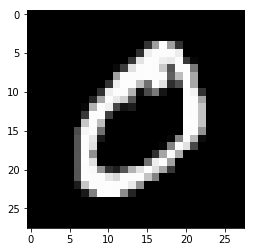

In [6]:
plt.imshow(train_X[1].reshape(28,28),cmap='gray')

In [6]:
mean_img = np.mean(train_X, axis=0)

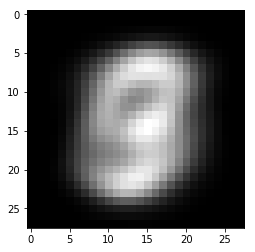

In [10]:
plt.imshow(mean_img.reshape((28,28)),cmap='gray')

In [7]:
std_img = np.std(train_X, axis=0)

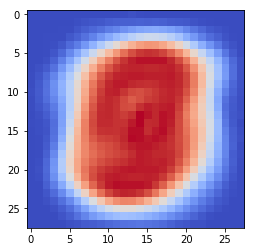

In [12]:
plt.figure()
plt.imshow(std_img.reshape((28,28)),cmap='coolwarm')

## 1. Vanilla autoencoder


In [8]:
from mpl_toolkits.axes_grid1 import AxesGrid


def montageM(fig,nrows,ncols,data,cmap='gray'):
    fig = plt.figure()
    grid = AxesGrid(fig, 111,  # similar to subplot(141)
                        nrows_ncols=(nrows,ncols),
                        axes_pad=0.05,
                        label_mode="1",
                        )
    for i in range(nrows*ncols):
        im = grid[i].imshow(data[i], interpolation="nearest",cmap=cmap)



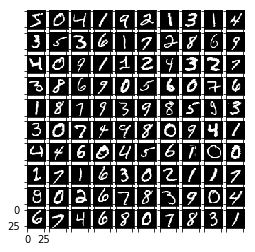

In [28]:

fig=plt.figure()
montageM(fig,nrows=10,ncols=10,data=train_X[:100].reshape(-1,28,28))


In [12]:
dims = [512,256,128,64]

n_features = train_X.shape[1]  # 784

X = tf.placeholder(dtype=tf.float32,shape=[None,n_features])


In [12]:
cur_input=X
n_input=n_features

Ws =[]

for layer_i,n_output in enumerate(dims):
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        W=tf.get_variable(name='W',shape=[n_input,n_output],initializer=tf.random_normal_initializer(mean=0.0,stddev=0.02))
        h=tf.matmul(cur_input,W)
        
        cur_input=tf.nn.relu(h)
        Ws.append(W)
        n_input=n_output

In [13]:
print(cur_input.get_shape())

(?, 64)


### Now comes the decoder part

In [14]:
Ws = Ws[::-1]
dims = dims[::-1][1:]+[train_X.shape[1]]
print(dims)

[128, 256, 512, 784]


In [15]:
for layer_i,num_outputs in enumerate(dims):
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        W = tf.transpose(Ws[layer_i])
        h = tf.matmul(cur_input,W)
        cur_input = tf.nn.relu(h)
        n_input=num_outputs

Y=cur_input

        

In [16]:
loss = tf.reduce_mean(tf.squared_difference(X,Y),1)

In [17]:
# and then take mean across loss??
loss = tf.reduce_mean(loss)


In [18]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [19]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)


In [23]:
def montage(images, saveto='montage.png'):
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    if len(images.shape) == 4 and images.shape[3] == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5
    else:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    plt.imsave(arr=m, fname=saveto)
    return m

0 2206.15
1 2156.89
2 2132.51
3 2101.87
4 2084.91


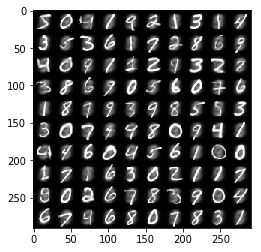

In [30]:
batch_size=100
n_epochs=5

batchInter = train_X.shape[0]/batch_size

#Samples to reconstruct
examples = train_X[:100]

imgs = []
fig,ax = plt.subplots(1,1)
for epoch_i in range(n_epochs):
    for batchOffset in range(batchInter):
        batchX = train_X[batchOffset * batch_size :  (batchOffset+1) * batch_size]
        sess.run(optimizer,feed_dict={X: batchX - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(loss, feed_dict={X: batchX - mean_img}))



(291, 291)


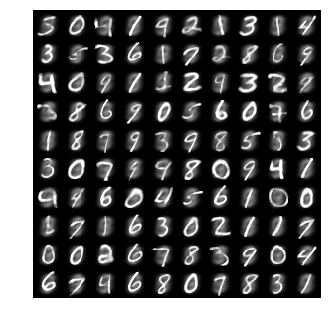

In [22]:
gif.build_gif(imgs, saveto='ae.gif', cmap='gray')

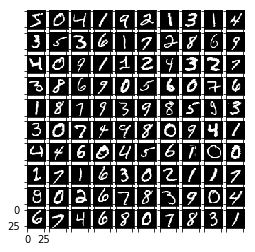

In [31]:
fig=plt.figure()
montageM(fig,nrows=10,ncols=10,data=train_X[:100].reshape(-1,28,28))


In [9]:
ipyd.Image(url='ae.gif',
           height=500, width=500)

## 2. Convolutional autoencoder

In [13]:
# First reset the prev graph, we need to reshape the input tensor to support convolution by converting it to a 4-D tensor
from tensorflow.python.framework.ops import reset_default_graph
reset_default_graph()

In [14]:
X = tf.placeholder(tf.float32, [None, n_features])
X_tensor = tf.reshape(X,[-1,28,28,1])


In [15]:
n_filters = [16,16,16]
filter_sizes = [4,4,4]

cur_input = X_tensor
n_input=1

Ws=[]
shapes=[]

for layer_i, n_output in enumerate(n_filters):
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        shapes.append(cur_input.get_shape().as_list())
        W = tf.get_variable(name='W',shape=[filter_sizes[layer_i],filter_sizes[layer_i],n_input,n_output],initializer=tf.random_normal_initializer(mean=0.0,stddev=0.02))
        h=tf.nn.conv2d(cur_input,W,strides=[1,2,2,1],padding='SAME')
        cur_input = tf.nn.relu(h)
        Ws.append(W)
        n_input=n_output
        

#### Conv decoder part..ding dong ding dong

In [16]:
Ws.reverse()
shapes.reverse()
n_filters.reverse()
# and append the last filter size which is our input image's number of channels
n_filters = n_filters[1:] + [1]
print(n_filters, filter_sizes, shapes)

[16, 16, 1] [4, 4, 4] [[None, 7, 7, 16], [None, 14, 14, 16], [None, 28, 28, 1]]


In [17]:
for layer_i, shape in enumerate(shapes):
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        W = Ws[layer_i]
        h= tf.nn.conv2d_transpose(cur_input,W,tf.stack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),strides=[1,2,2,1],padding='SAME')
        cur_input=tf.nn.relu(h)
        

In [19]:
Y = cur_input
Y = tf.reshape(Y, [-1, n_features])

In [22]:
loss = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X,Y),1))
learning_rate=0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess = tf.Session()
tf.global_variables_initializer().run(session=sess)


0 2050.33
1 1926.56
2 1882.91
3 1856.33
4 1844.38


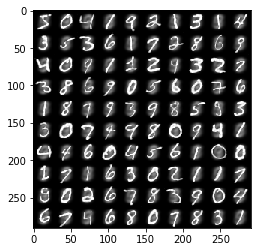

In [24]:
batch_size=100
n_epochs=5

batchInter = train_X.shape[0]/batch_size

#Samples to reconstruct
examples = train_X[:100]

imgs = []
fig,ax = plt.subplots(1,1)
for epoch_i in range(n_epochs):
    for batchOffset in range(batchInter):
        batchX = train_X[batchOffset * batch_size :  (batchOffset+1) * batch_size]
        sess.run(optimizer,feed_dict={X: batchX - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
2    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(loss, feed_dict={X: batchX - mean_img}))

In [27]:
# fully-conected layer - the guy's a Wx+b
def fc(x, inputFeatures, outputFeatures, scope=None, with_w=False):
    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("W", [inputFeatures, outputFeatures], tf.float32, tf.random_normal_initializer(stddev=0.02))
        bias = tf.get_variable("b", [outputFeatures], initializer=tf.constant_initializer(0.0))
        if with_w:
            return tf.matmul(x, matrix) + bias, matrix, bias
        else:
            return tf.matmul(x, matrix) + bias
        
#Here we'll play around with leaky relu instead of normal relu, as it acts as a much better activation function

def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

## Variational autoencoder

#### <font color='red'> Encoder Logic </font>

In [40]:
reset_default_graph()
n_filters = [16,32]
n_input=1
n_z=20
filter_sizes = [5,5]
batch_size=100

# Load input

X = tf.placeholder(dtype=tf.float32,shape=[None,n_features])
# Reshape it to 4D for convol filter
X_tensor = tf.reshape(X,[-1,28,28,1])

#Next layer is a convolutional weight layer like above
cur_input = X_tensor




Ws =[]
shapes=[]

# encoder cycle

for layer_i,n_output in enumerate(n_filters):
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        shapes.append(cur_input.get_shape().as_list())
        W = tf.get_variable(name='W',shape=[filter_sizes[layer_i],filter_sizes[layer_i],n_input,n_output],initializer=tf.random_normal_initializer(mean=0.0,stddev=0.02))
        h=tf.nn.conv2d(cur_input,W,strides=[1,2,2,1],padding='SAME')
        cur_input = lrelu(h)
        Ws.append(W)
        n_input=n_output
        
# Now take mean and stdev vector     

#1.convert the conv output  to fc

with tf.variable_scope("mean_std_encoder"):
    flatten = tf.reshape(cur_input,[batch_size,7*7*32])
    w_mean =  fc(flatten,7*7*32,n_z,"w_mean")
    w_stddev = fc(flatten,7*7*32,n_z,"w_stddev")


#now we have to find the sampled latent vector
samples = tf.random_normal([batch_size,n_z],0,1,dtype=tf.float32)
gen_guessd_z = w_mean + (w_stddev * samples)




#### <font color='blue'> Variational decoder and loss functions </font>

In [41]:
Ws.reverse()
shapes.reverse()
n_filters.reverse()
n_filters = n_filters[1:] # we'll add 1 later, as we need a sigmoid instead of lrelu

with tf.variable_scope("mean_std_decoder"):
    #We have to convert the n_z size to 7*7*32 
    z_develop = fc(gen_guessd_z,n_z,7*7*32,scope='z_matrix')
    
    
    z_4d_conv = tf.reshape(z_develop,[batch_size,7,7,32])
    z_mat = tf.nn.relu(z_4d_conv)

for layer_i,shape in enumerate(shapes[:-1]):
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        W = Ws[layer_i]
        h= tf.nn.conv2d_transpose(cur_input,W,tf.stack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),strides=[1,2,2,1],padding='SAME')
        cur_input=tf.nn.relu(h)

#Now the last decoder layer
W = Ws[-1]
shape = shapes[-1]
h=tf.nn.conv2d_transpose(cur_input,W,tf.stack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),strides=[1,2,2,1],padding='SAME')
out = tf.nn.sigmoid(h)
out_reshaped = tf.reshape(out,[batch_size,28*28])
#Now we'll decide on the loss.. Both for unit gaussian(latent) and decoder output(generated loss)
# generation_loss = mean(square(generated_image - real_image))  
# latent_loss = KL-Divergence(latent_variable, unit_gaussian)  
# loss = generation_loss + latent_loss  


#1. BCE Loss for gen
epsilon = 1e-10
generation_loss = -1 * tf.reduce_sum(X * tf.log(epsilon+out_reshaped)+(1-X)*tf.log(epsilon+1-out_reshaped) ,1)

#2. now latent loss (KL-divergence)
#  1/2 * SIGMA(z_mean^2 + z_stddev^2 - log(z_stddev^2)-1)

latent_loss = 0.5 * tf.reduce_sum(tf.square(w_mean)+tf.square(w_stddev) - tf.log(tf.square(w_stddev))-1,1)

#3. Now total loss

loss = tf.reduce_mean(generation_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

In [ ]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

n_epochs=5
Y=out_reshaped
batchInter = train_X.shape[0]/batch_size

#Samples to reconstruct
examples = train_X[:100]

imgs = []
fig,ax = plt.subplots(1,1)
for epoch_i in range(n_epochs):
    for batchOffset in range(batchInter):
        batchX = train_X[batchOffset * batch_size :  (batchOffset+1) * batch_size]
        sess.run(optimizer,feed_dict={X: batchX - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(loss, feed_dict={X: batchX - mean_img}))